In [ ]:
!pip install pyarrow
!pip install fastparquet
!pip install tabulate
!pip install seaborn

In [95]:
import pandas as pd

# Replace 'your_file_path' with the actual path to your file in Google Drive
file_path = '/home/abrar/Desktop/Code/Temporal HPC/job_table.parquet'

# Use pd.read_parquet instead of pd.read_csv to read parquet files
df = pd.read_parquet(file_path)

# Now you can work with the dataframe 'df'
# print(df.head())

In [96]:
from tabulate import tabulate

print(tabulate(df.head(5), headers='keys', tablefmt='psql'))
# print(tabulate(df_filtered.head(), headers='keys', tablefmt='psql'))

+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [97]:
import numpy as np

# 2. Initial validation

print("---- Data Info ----")
df.info()

# print("\n---- First 5 rows ----")
# print(df.head())

# print("\n---- Last 5 rows ----")
# print(df.tail())

# 3. Check for duplicates
# Convert columns containing numpy arrays to tuples
for col in df.select_dtypes(include=[object]).columns:
    # Check if the column contains numpy arrays
    if any(isinstance(x, (np.ndarray, list)) for x in df[col]):
        df[col] = df[col].apply(tuple)

duplicates_count = df.duplicated().sum()
print(f"\nNumber of duplicated rows: {duplicates_count}")

# drop duplicates if any
if duplicates_count > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates dropped.")

---- Data Info ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231238 entries, 0 to 231237
Data columns (total 35 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   cores_alloc_layout      231238 non-null  object             
 1   cores_allocated         231238 non-null  object             
 2   cores_per_task          231238 non-null  int64              
 3   derived_ec              231238 non-null  object             
 4   eligible_time           231238 non-null  datetime64[us, UTC]
 5   end_time                231238 non-null  datetime64[us, UTC]
 6   group_id                231238 non-null  int64              
 7   job_id                  231238 non-null  int64              
 8   job_state               231238 non-null  object             
 9   nodes                   231238 non-null  object             
 10  num_cores_req           231238 non-null  int64              
 11  num_co

In [98]:
# Example critical columns
critical_columns = [
    'num_cores_req',
    'run_time',
    'time_limit',
    'mem_req',
    'num_nodes_req',   # optional
    'num_gpus_req',    # optional
]

# 1. Convert them to numeric if they aren't already
for col in critical_columns:
    # coerce = convert invalid parsing to NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 2. Check for negative or extreme values
for col in critical_columns:
    negative_count = (df[col] < 0).sum()
    if negative_count > 0:
        print(f"Column {col} has {negative_count} negative entries. Investigate or drop/fix them.")

# 3. Handle missing numeric values (NaN)
# Decide a policy. Example: drop rows missing these critical values:
df.dropna(subset=critical_columns, inplace=True)

# 4. If run_time is zero or negative (some HPC logs might have 0 for failed or instantly finished jobs)
# Decide how to handle them. Let's say we drop them for now:
zero_runtime_count = (df['run_time'] <= 0).sum()
if zero_runtime_count > 0:
    print(f"{zero_runtime_count} jobs have run_time <= 0. Dropping these.")
    df = df[df['run_time'] > 0]
print("Cleaned subset size:", df.shape)


66 jobs have run_time <= 0. Dropping these.
Cleaned subset size: (231172, 35)


In [99]:
# Ensure your 'submit_time' is in datetime format
df['submit_time'] = pd.to_datetime(df['submit_time'], errors='coerce', utc=True)

# Filter jobs in, say, June 2020 (example range)
start_date = pd.to_datetime("2020-06-01", utc=True)
end_date = pd.to_datetime("2020-06-10", utc=True)
df_small = df[(df['submit_time'] >= start_date) & (df['submit_time'] < end_date)]

print("Subset size (date-based):", df_small.shape)


Subset size (date-based): (6929, 35)


In [100]:
def convert_to_list(data):
    print(f"Input data: {data}, Data type: {type(data)}")  # Print input data and type
    if isinstance(data, str):
        try:
            # Convert string to list of numeric values
            numeric_list = [float(num) for num in data.strip('()').split(',')]
            print(f"Returning list: {numeric_list}")  # Print the list being returned
            return numeric_list
        except (ValueError, SyntaxError):
            print("Error during string conversion")
            return []
    elif isinstance(data, tuple):
        try:
            # Convert tuple to list of numeric values
            numeric_list = [float(num) for num in data]
            print(f"Returning list: {numeric_list}")  # Print the list being returned
            return numeric_list
        except ValueError:
            print("Error during tuple conversion")
            return []
    else:
        print("Data is not a string or tuple")
        return []  # Handle other data types if needed

In [ ]:
# Apply the conversion function using .loc
df_small.loc[:, 'node_power_list'] = df_small['node_power_consumption'].apply(convert_to_list)
df_small.loc[:, 'cpu_power_list'] = df_small['cpu_power_consumption'].apply(convert_to_list)
df_small.loc[:, 'mem_power_list'] = df_small['mem_power_consumption'].apply(convert_to_list)

# Calculate mean power consumption using .loc
df_small.loc[:, 'mean_node_power'] = df_small['node_power_list'].apply(lambda x: np.mean(x) if x else np.nan)
df_small.loc[:, 'mean_cpu_power'] = df_small['cpu_power_list'].apply(lambda x: np.mean(x) if x else np.nan)
df_small.loc[:, 'mean_mem_power'] = df_small['mem_power_list'].apply(lambda x: np.mean(x) if x else np.nan)

print(df_small[['mean_node_power', 'mean_cpu_power', 'mean_mem_power']])

In [ ]:
# Convert to float to ensure accurate mean calculation
df_small['mean_node_power'] = df_small['node_power_consumption'].astype(float).mean()
df_small['mean_cpu_power'] = df_small['cpu_power_consumption'].astype(float).mean()
df_small['mean_mem_power'] = df_small['mem_power_consumption'].astype(float).mean()

# Now you have the mean power values in these columns:
print(df_small[['mean_node_power', 'mean_cpu_power', 'mean_mem_power']])

ValueError: setting an array element with a sequence.

In [89]:
print(df_small['mean_node_power'].nunique())
print(df_small['mean_cpu_power'].nunique())
print(df_small['mean_mem_power'].nunique())

0
0
0


In [64]:
import numpy as np


# Example preprocessing to handle nested or inconsistent data

# Ensure power consumption columns are processed correctly
power_columns = ['node_power_consumption', 'mem_power_consumption', 'cpu_power_consumption']

# Flatten or aggregate nested structures in power consumption columns
for col in power_columns:
    df_small[col] = df_small[col].apply(
        lambda x: np.sum(x) if isinstance(x, (list, np.ndarray)) else pd.to_numeric(x, errors='coerce')
    )

# Handle missing values
df_small[power_columns] = df_small[power_columns].fillna(0)

/tmp/ipykernel_15839/2240228399.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small[col] = df_small[col].apply(
/tmp/ipykernel_15839/2240228399.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small[power_columns] = df_small[power_columns].fillna(0)


In [65]:
import numpy as np


# Example preprocessing to handle nested or inconsistent data

# Ensure power consumption columns are processed correctly
power_columns = ['node_power_consumption', 'mem_power_consumption', 'cpu_power_consumption']

# Flatten or aggregate nested structures in power consumption columns
for col in power_columns:
    df_small[col] = df_small[col].apply(
        lambda x: np.sum(x) if isinstance(x, (list, np.ndarray)) else pd.to_numeric(x, errors='coerce')
    )

# Handle missing values
df_small[power_columns] = df_small[power_columns].fillna(0)

# Ensure 'submit_time' is in datetime format and set as index
df_small['submit_time'] = pd.to_datetime(df_small['submit_time'], errors='coerce', utc=True)
df_small.set_index('submit_time', inplace=True)

# Resampling to aggregate data hourly for visualization
power_trends = df_small[power_columns].resample('H').sum()

# Aggregating job submissions hourly
job_submissions = df_small.resample('H').size()



/tmp/ipykernel_15839/3288450684.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small[col] = df_small[col].apply(
/tmp/ipykernel_15839/3288450684.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small[power_columns] = df_small[power_columns].fillna(0)
/tmp/ipykernel_15839/3288450684.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

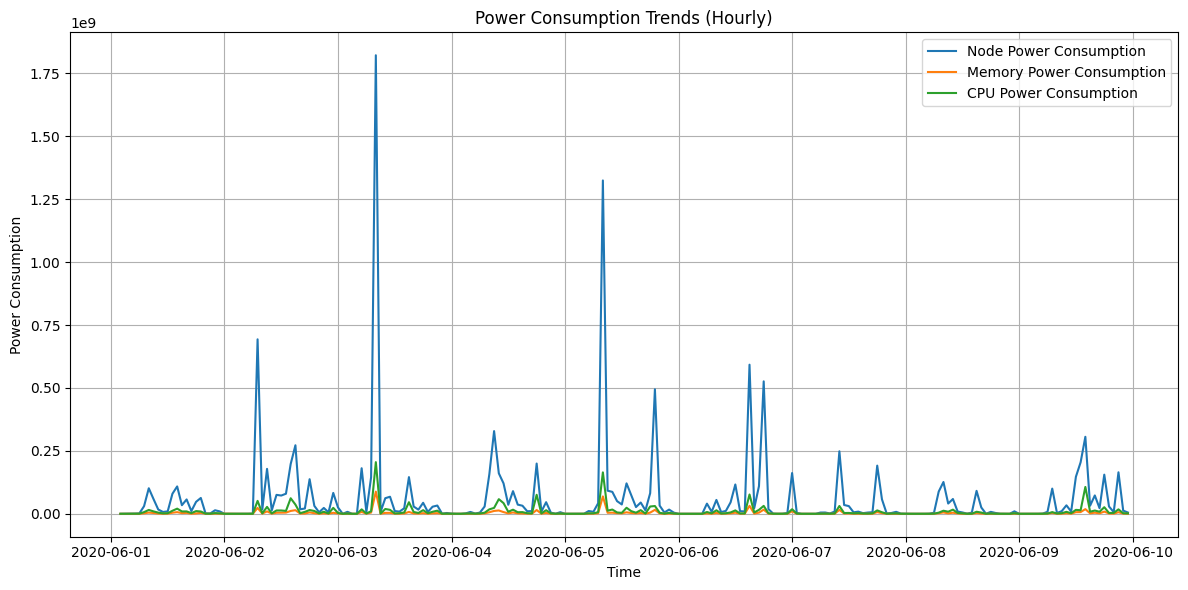

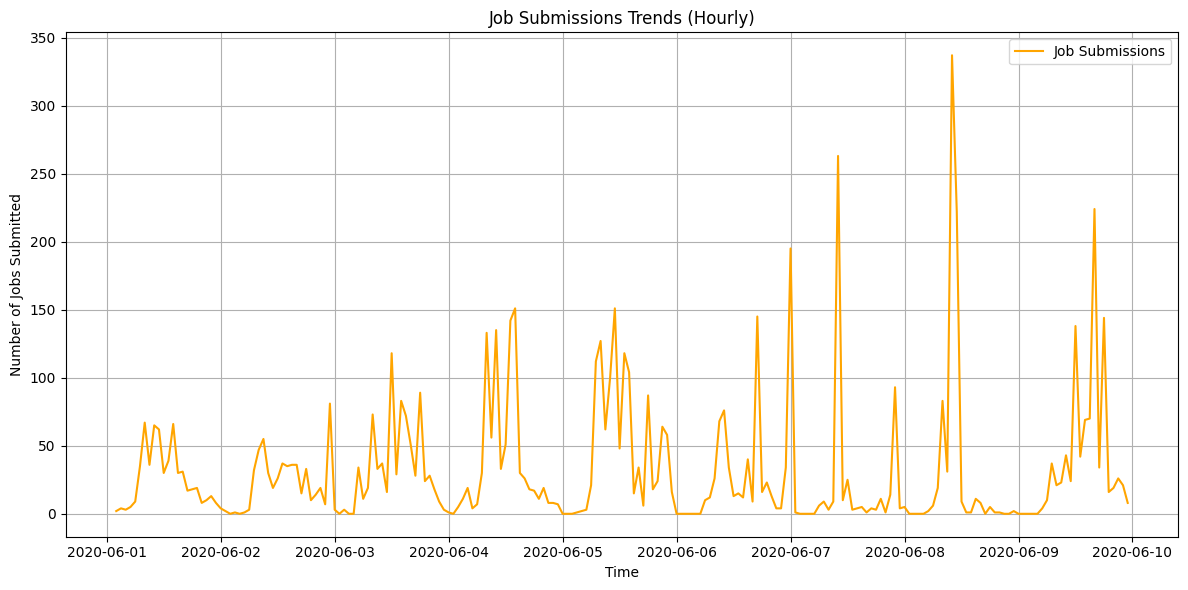

In [66]:
import matplotlib.pyplot as plt

# Plotting power consumption trends
plt.figure(figsize=(12, 6))
plt.plot(power_trends.index, power_trends['node_power_consumption'], label='Node Power Consumption')
plt.plot(power_trends.index, power_trends['mem_power_consumption'], label='Memory Power Consumption')
plt.plot(power_trends.index, power_trends['cpu_power_consumption'], label='CPU Power Consumption')
plt.title('Power Consumption Trends (Hourly)')
plt.xlabel('Time')
plt.ylabel('Power Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting job submissions trends
plt.figure(figsize=(12, 6))
plt.plot(job_submissions.index, job_submissions, label='Job Submissions', color='orange')
plt.title('Job Submissions Trends (Hourly)')
plt.xlabel('Time')
plt.ylabel('Number of Jobs Submitted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Average Power Analysis
 

In [1]:
import pandas as pd
file_path = '/home/abrar/Desktop/Code/Temporal HPC/pm100_job _w_data_avg_power.csv'

# Read the second sheet (index 1, since indexing starts at 0)
df = pd.read_csv(file_path)

# df.describe()

,cores_per_task,group_id,job_id,num_cores_req,num_cores_alloc,num_nodes_req,num_nodes_alloc,num_tasks,partition,priority,...,threads_per_core,time_limit,num_gpus_req,num_gpus_alloc,mem_req,mem_alloc,user_id,mean_node_power,mean_cpu_power,mean_mem_power
count,231125.000000,231125.000000,2.311250e+05,231125.000000,231125.000000,231125.000000,231125.000000,221675.000000,231125.000000,2.311250e+05,...,904.000000,231125.000000,231125.000000,231125.000000,231125.000000,231125.000000,231125.000000,231125.000000,228259.000000,228259.000000
mean,16.735022,25210.806564,3.120949e+06,354.062291,431.125166,4.209943,4.213330,41.265862,0.989828,1.837031e+05,...,1.057522,708.707825,14.517499,15.005616,696.186034,827.640004,668.892400,2955.120394,511.998417,160.513134
std,17.760734,618.779528,1.801781e+06,1338.880128,1667.201261,14.737369,14.737385,331.951755,0.112729,1.038443e+05,...,0.400731,633.923877,55.982314,57.320243,2489.602421,3080.853534,571.835019,10245.160423,1883.557146,555.483430
min,1.000000,915.000000,5.000000e+00,1.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,20.000000,10.000000,28.000000
25%,1.000000,25200.000000,1.560666e+06,24.000000,64.000000,1.000000,1.000000,4.000000,1.000000,9.053000e+04,...,1.000000,60.000000,4.000000,4.000000,83.000000,118.000000,182.000000,587.500000,82.230577,36.000000
50%,16.000000,25200.000000,3.119588e+06,128.000000,128.000000,1.000000,1.000000,4.000000,1.000000,1.781850e+05,...,1.000000,540.000000,4.000000,4.000000,234.000000,237.000000,564.000000,819.000000,119.952381,38.000000
75%,32.000000,25200.000000,4.683413e+06,128.000000,128.000000,2.000000,2.000000,32.000000,1.000000,2.631480e+05,...,1.000000,1440.000000,4.000000,4.000000,240.000000,332.000000,1205.000000,1328.750000,263.770245,72.000000
max,128.000000,53925.000000,6.242697e+06,32768.000000,32768.000000,256.000000,256.000000,32768.000000,2.000000,1.025546e+07,...,4.000000,1440.000000,1024.000000,1024.000000,61500.000000,61500.000000,1743.000000,313297.500000,78210.285714,15565.000000


In [4]:
print(df.describe())

       cores_per_task       group_id        job_id  num_cores_req  \
count   231125.000000  231125.000000  2.311250e+05  231125.000000   
mean        16.735022   25210.806564  3.120949e+06     354.062291   
std         17.760734     618.779528  1.801781e+06    1338.880128   
min          1.000000     915.000000  5.000000e+00       1.000000   
25%          1.000000   25200.000000  1.560666e+06      24.000000   
50%         16.000000   25200.000000  3.119588e+06     128.000000   
75%         32.000000   25200.000000  4.683413e+06     128.000000   
max        128.000000   53925.000000  6.242697e+06   32768.000000   

       num_cores_alloc  num_nodes_req  num_nodes_alloc      num_tasks  \
count    231125.000000  231125.000000    231125.000000  221675.000000   
mean        431.125166       4.209943         4.213330      41.265862   
std        1667.201261      14.737369        14.737385     331.951755   
min           4.000000       1.000000         1.000000       0.000000   
25%          

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231125 entries, 0 to 231124
Data columns (total 41 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   cores_alloc_layout      231125 non-null  object 
 1   cores_allocated         231125 non-null  object 
 2   cores_per_task          231125 non-null  int64  
 3   derived_ec              231125 non-null  object 
 4   eligible_time           231125 non-null  object 
 5   end_time                231125 non-null  object 
 6   group_id                231125 non-null  int64  
 7   job_id                  231125 non-null  int64  
 8   job_state               231125 non-null  object 
 9   nodes                   231125 non-null  object 
 10  num_cores_req           231125 non-null  int64  
 11  num_cores_alloc         231125 non-null  int64  
 12  num_nodes_req           231125 non-null  int64  
 13  num_nodes_alloc         231125 non-null  int64  
 14  num_tasks           

In [3]:
df_avg_power = df[['mean_node_power', 'mean_cpu_power', 'mean_mem_power']]
df_avg_power.describe()

,mean_node_power,mean_cpu_power,mean_mem_power
count,231125.000000,228259.000000,228259.000000
mean,2955.120394,511.998417,160.513134
std,10245.160423,1883.557146,555.483430
min,20.000000,10.000000,28.000000
25%,587.500000,82.230577,36.000000
50%,819.000000,119.952381,38.000000
75%,1328.750000,263.770245,72.000000
max,313297.500000,78210.285714,15565.000000


In [3]:
# Calculate IQR for each column
Q1 = df_avg_power[['mean_node_power', 'mean_cpu_power', 'mean_mem_power']].quantile(0.25)
Q3 = df_avg_power[['mean_node_power', 'mean_cpu_power', 'mean_mem_power']].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows where values are outside bounds
filtered_df = df_avg_power[
    (df_avg_power['mean_node_power'] >= lower_bound['mean_node_power']) & 
    (df_avg_power['mean_node_power'] <= upper_bound['mean_node_power']) &
    (df_avg_power['mean_cpu_power'] >= lower_bound['mean_cpu_power']) & 
    (df_avg_power['mean_cpu_power'] <= upper_bound['mean_cpu_power']) &
    (df_avg_power['mean_mem_power'] >= lower_bound['mean_mem_power']) & 
    (df_avg_power['mean_mem_power'] <= upper_bound['mean_mem_power'])
]

# Display summary of filtered dataset
# filtered_df.describe()

In [4]:
# Calculate IQR for each column
Q1 = df_avg_power[['mean_node_power', 'mean_cpu_power', 'mean_mem_power']].quantile(0.25)
Q3 = df_avg_power[['mean_node_power', 'mean_cpu_power', 'mean_mem_power']].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows where values are outside bounds
filtered_df_IQR = df_avg_power[
    (df_avg_power['mean_node_power'] >= lower_bound['mean_node_power']) & 
    (df_avg_power['mean_node_power'] <= upper_bound['mean_node_power']) &
    (df_avg_power['mean_cpu_power'] >= lower_bound['mean_cpu_power']) & 
    (df_avg_power['mean_cpu_power'] <= upper_bound['mean_cpu_power']) &
    (df_avg_power['mean_mem_power'] >= lower_bound['mean_mem_power']) & 
    (df_avg_power['mean_mem_power'] <= upper_bound['mean_mem_power'])
]

# Display summary of filtered dataset
# filtered_df_IQR.describe()

/tmp/ipykernel_9996/3006945432.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


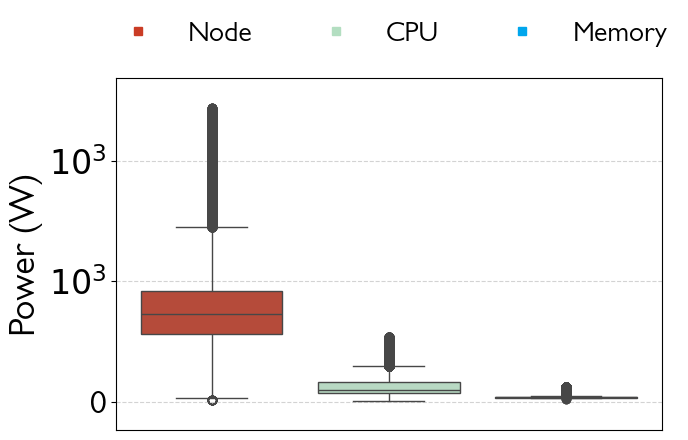

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

# Select the columns for the box plot
power_data = filtered_df_IQR[['mean_node_power', 'mean_cpu_power', 'mean_mem_power']]

# Convert the DataFrame to long-form
power_data_long = pd.melt(power_data, var_name='Power Type', value_name='Power Value')

# Determine dynamic y-axis limits
y_min = power_data_long['Power Value'].min()
y_max = power_data_long['Power Value'].max()
y_padding = (y_max - y_min) * 0.1  # Add 10% padding on both sides

# Set the font to Gill Sans
plt.rcParams['font.family'] = 'Gill Sans'

# Adjusted box plot with the requested updates
fig, ax = plt.subplots(figsize=(7, 4.5))
sns.boxplot(
    x='Power Type', 
    y='Power Value', 
    data=power_data_long, 
    ax=ax, 
    palette=['#ca3c25', '#b3dec1', '#00a6ed']
)

# Hide x-axis ticks and labels
ax.set_xticks([])
ax.set_xlabel('')  # Remove x-axis label

# Set the y-axis limits dynamically
ax.set_ylim(y_min - y_padding, y_max + y_padding)

# Add a legend for the power types
legend_labels = ['Node', 'CPU', 'Memory']
legend_colors = ['#ca3c25', '#b3dec1', '#00a6ed']

# Add custom legend
for label, color in zip(legend_labels, legend_colors):
    ax.plot([], [], label=label, color=color, marker='s', linestyle='')

# Add legend to appear at the upper center
plt.legend(
    title_fontsize=18, 
    fontsize=20, 
    loc='lower center', 
    bbox_to_anchor=(0.5, 1.02),  # Centered above the plot
    ncol=3,  # Arrange legend items in 3 columns
    frameon=False
)

# Add labels and customize
ax.set_ylabel('Power (W)', fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=24)

# Add gridlines for the y-axis
ax.grid(which='both', axis='y', color='lightgrey', linestyle='dashed', zorder=0)

# Format y-axis ticks as scientific notation (e.g., 10^4)
def scientific_notation_formatter(value, _):
    return f'$10^{{{int(np.log10(value))}}}$' if value > 0 else '0'

ax.yaxis.set_major_formatter(FuncFormatter(scientific_notation_formatter))

# Add a label for scientific notation on the plot
# ax.text(0, 1.02, r'$\times 10^4$', transform=ax.transAxes, fontsize=24, va='bottom', ha='left')

# Tight layout and save
plt.tight_layout()
plt.savefig("avg_power_node_cpu_mem.pdf", bbox_inches='tight')

# Show the plot
plt.show()
